In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
import torch.multiprocessing as mp
import torchvision.transforms as transforms
import torchvision.models as models

from torchtoolbox.transform import Cutout
from torchtoolbox.tools import mixup_data, mixup_criterion

from torch import Tensor
from torch.nn import functional as F
from torch.autograd import Variable

In [2]:
lr = 1e-4
batchSize = 100
workers = 16
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transfrom = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandAugment(),
    transforms.RandomAutocontrast(),
    transforms.RandomHorizontalFlip(),
    Cutout(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
transfromTest = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandAugment(),
    transforms.RandomAutocontrast(),
    transforms.RandomHorizontalFlip(),
    Cutout(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
Labels = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6}
classes = len(Labels)

In [5]:
import os
from PIL import Image
from torch.utils import data
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
class SeedlingData(data.Dataset):
    def __init__(self, root, transforms=None, train=True, test=False):
        self.test = test
        self.transforms = transforms
        if self.test:
            imgs = [os.path.join(root, img) for img in os.listdir(root)]
            self.imgs = imgs
        else:
            img_labels = [os.path.join(root, img) for img in os.listdir(root)]
            imgs = []
            for imglabel in img_labels:
                for imgname in os.listdir(imglabel):
                    imgpath = os.path.join(imglabel, imgname)
                    imgs.append(imgpath)
            trainval_file, val_file = train_test_split(imgs,
                                                       test_size=0.2,
                                                       random_state=42)
            if train:
                self.imgs = trainval_file
            else:
                self.imgs = val_file

    def __getitem__(self, index):
        img_path = self.imgs[index]
        img_path = img_path.replace("\\", "/")
        if self.test:
            label = -1
        else:
            labelname = img_path.split('/')[-2]
            label = Labels[labelname]
        data = Image.open(img_path).convert('RGB')
        data = self.transforms(data)
        return data, label

    def __len__(self):
        return len(self.imgs)

In [7]:
dataset_train = SeedlingData('./datasets/train',
                             transforms=transfrom,
                             train=True)
dataset_test = SeedlingData('./datasets/train',
                            transforms=transfrom,
                            train=False)


In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=dataset_train,
    batch_size=batchSize,
    #num_workers=workers,
    pin_memory=True,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=dataset_test,
    batch_size=batchSize,
    #num_workers=workers,
    pin_memory=True,
    shuffle=False)


ConvNeXt

In [9]:
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x: Tensor) -> Tensor:
        x = x.permute(0, 2, 3, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias,
                         self.eps)
        x = x.permute(0, 3, 1, 2)
        return x

In [10]:
from Model.convnext import convnext_base

CONVNEXT = convnext_base(pretrained=True)
print(CONVNEXT)
CONVNEXT.norm = nn.LayerNorm(1024, eps=1e-06, elementwise_affine=True)

CONVNEXT.head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1024, 512,True), nn.GELU(), nn.Dropout(0.2), nn.Linear(512, 7,True),
    nn.LogSoftmax(dim=1))


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to C:\Users\dell/.cache\torch\hub\checkpoints\convnext_base_1k_224_ema.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU()
        (pwconv2): Linear(in_features=512, out_features=128, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [11]:
# ALEX = models.alexnet(pretrained=True, progress=True)
# ALEX.classifier[6] == nn.Linear(4096, classes)
# VGG = models.vgg19(pretrained=True, progress=True)
# VGG.classifier[6] == nn.Linear(4096, classes)

# DENSENET = models.densenet169(pretrained=True, progress=True)
# DENSENET.classifier = nn.Linear(1664, 7, True)

# RESNET = models.resnet50(pretrained=True, progress=True)
# channel_in = RESNET.fc.in_features
# RESNET.fc = nn.Linear(channel_in, classes)
# MOBILE = models.mobilenet_v3_large(pretrained=True, progress=True)
# print(MOBILE)
# INCEPTION = models.inception_v3(pretrained=True,progress=True,num_classes=classes,init_weights=True)

# GOOGLE = models.googlenet(pretrained=True,progress=True,num_classes=classes,init_weights=True)
# MNASNET = models.mnasnet1_0(pretrained=True,progress=True,num_classes=classes)

# modelPool = [ALEX, VGG, DENSENET, RESNET, MOBILE, CONVNEXT]
# namePool = ['ALEX', 'VGG', 'DENSENET', 'RESNET', 'MOBILE', 'CONVNEXT']
modelPool = [CONVNEXT]
namePool = ['CONVNEXT']


In [16]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    sum_loss = 0
    lr_now = lr
    total_num = len(train_loader.dataset)
    print(total_num, len(train_loader))
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device,
                               non_blocking=True), target.to(device,
                                                             non_blocking=True)
        data, labels_a, labels_b, lam = mixup_data(data, target, alpha)
        optimizer.zero_grad()
        # output = model(data)
        with torch.cuda.amp.autocast():
            loss = mixup_criterion(criterion, model(data), labels_a, labels_b,
                                   lam)

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scheduler.step()
        #lr_now = scheduler.get_last_lr()
        scaler.update()
        # loss.backward()
        # optimizer.step()
        print_loss = loss.data.item()
        sum_loss += print_loss
        if (batch_idx + 1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tlr={}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                    100. * (batch_idx + 1) / len(train_loader), loss.item(),lr_now))
    ave_loss = sum_loss / len(train_loader)
    print('Epoch:{},loss:{},lr:{}'.format(epoch, ave_loss, lr_now))


# 验证过程
def val(model, device, test_loader):
    global ACC
    model.eval()
    test_loss = 0
    correct = 0
    total_num = len(test_loader.dataset)
    print(total_num, len(test_loader))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(
                device)
            output = model(data)
            loss = criterion(output, target)
            _, pred = torch.max(output.data, 1)
            correct += torch.sum(pred == target)
            print_loss = loss.data.item()
            test_loss += print_loss
        correct = correct.data.item()
        acc = correct / total_num
        avgloss = test_loss / len(test_loader)
        LOSS_LIST.append(avgloss)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(avgloss, correct, len(test_loader.dataset), 100 * acc))
        ACC_LIST.append(acc)
        if acc > ACC:
            torch.save(
                model, namePool[EPOCHS_COUNT] + '/' + namePool[EPOCHS_COUNT] +
                str(epoch) + '_' + str(round(acc, 3)) + '.pth')
            ACC = acc

22967 230
Epoch:1,loss:1.347849456641985,lr:0.0001
5742 58

Val set: Average loss: 1.0725, Accuracy: 3460/5742 (60%)

22967 230
Epoch:2,loss:1.1137610199658767,lr:0.0001
5742 58

Val set: Average loss: 0.9781, Accuracy: 3663/5742 (64%)

22967 230
Epoch:3,loss:1.042405885976294,lr:0.0001
5742 58

Val set: Average loss: 0.9423, Accuracy: 3755/5742 (65%)

22967 230
Epoch:4,loss:0.9440031265435012,lr:0.0001
5742 58

Val set: Average loss: 0.9008, Accuracy: 3841/5742 (67%)

22967 230
Epoch:5,loss:0.8209371375000996,lr:0.0001
5742 58

Val set: Average loss: 0.9128, Accuracy: 3883/5742 (68%)

22967 230
Epoch:6,loss:0.7092621830494508,lr:0.0001
5742 58

Val set: Average loss: 0.9578, Accuracy: 3849/5742 (67%)

22967 230
Epoch:7,loss:0.6433404338100682,lr:0.0001
5742 58

Val set: Average loss: 0.9787, Accuracy: 3869/5742 (67%)

22967 230
Epoch:8,loss:0.571346732876871,lr:0.0001
5742 58

Val set: Average loss: 1.0453, Accuracy: 3906/5742 (68%)

22967 230
Epoch:9,loss:0.5596668015679588,lr:0.0001

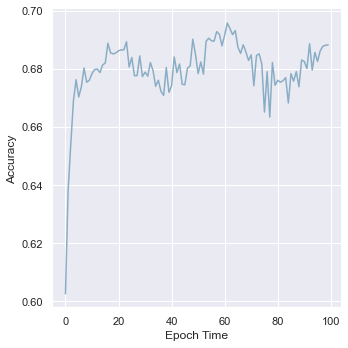

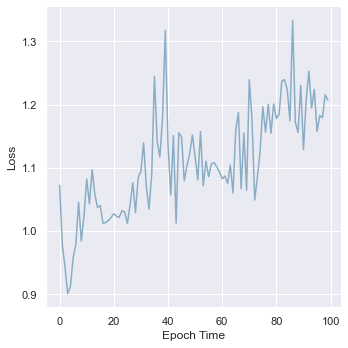

In [18]:
MODEL = 0
for model in modelPool:

    criterion = nn.CrossEntropyLoss()
    #criterion = SoftTargetCrossEntropy()
    # model.fc = nn.Sequential(nn.Linear(2048,1024), nn.ReLU(), nn.Dropout(0.2),
    #                          nn.Linear(512, 7), nn.LogSoftmax(dim=1))
    # model.fc = nn.Sequential(nn.LogSoftmax(dim=1))

    model.to(device)
    # 选择简单暴力的Adam优化器，学习率调低
    #optimizer = optim.Adam(model_ft.parameters(), lr=modellr)
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    #optimizer = optim.RAdam(model.parameters(), lr=lr)
    cosine_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                           T_max=20,
                                                           eta_min=1e-9)
    scaler = torch.cuda.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.01,
        steps_per_epoch=len(dataset_train),
        epochs=epochs
        )
    alpha = 0.2

    EPOCHS_COUNT = 0
    ACC_LIST = []
    LOSS_LIST = []
    ACC = 0

    if os.path.isdir(namePool[MODEL]):
        pass
    else:
        os.mkdir(namePool[MODEL])
        MODEL += 1
    # 训练
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        cosine_schedule.step()
        val(model, device, test_loader)

    sns.set(palette='twilight')
    sns.relplot(kind='line', data=ACC_LIST)
    plt.xlabel("Epoch Time")
    plt.ylabel("Accuracy")
    #plt.ylim(top=1,bottom=0)
    sns.relplot(kind='line', data=LOSS_LIST)
    plt.xlabel("Epoch Time")
    plt.ylabel("Loss")
    print(ACC_LIST)
    print(LOSS_LIST)